In [1]:
!pip install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 8.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [29]:
import os
import sys
import pandas as pd
# import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: DelftStack
  # This is added back by InteractiveShellApp.init_path()


In [4]:
#import statsmodels.api as sm
from statsmodels.tsa import ar_model, arima_process, arima, arima_model
from statsmodels.tsa.ar_model import AutoReg

"""
n_samples: int
ar: numpy.ndarray
ma: numpy.ndarray
ar2: numpy.ndarray
alphas:numpy.ndarray
betas:numpy.ndarray

variables para diseñar una señal aleatoria. 
"""
# Simulate an AR(2) process
alphas = np.array([.93, .0333])
betas = np.array([0.])
# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
n_samples = 2048
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ar2 = arima_process.arma_generate_sample(ar=ar, ma=ma, nsample=n_samples) 


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Data preparation

In [16]:
"""
split_sequence: funcion

funcion que recopila los valores de un patron y los retorna  en dos arreglos 

"""

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
  #find the end of this pattern
    end_ix = i + n_steps
  # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
print(type(split_sequence))


<class 'function'>


In [18]:
"""
dataset: numpy.ndarray
train_size: int
train_dataset: ndarray
test_dataset: ndarray
step_back: int
X_train:  ndarray
Y_train: ndarray
X_test: ndarray
Y_test: ndarray

usamos las reglas de sturge en train_size para saber la cantidad optima de contenedores en la grafica del histograma.
agrupamos los valores de la señal aleatoria en arreglos.
se tomo dos arreglos diferentes, que vienen de los datos recompilados de la señal aleatoria

"""

# split into train and test sets
dataset = ar2
n_steps = 3
step_back = n_steps

train_size = int(len(dataset) * 0.67) 
train_dataset, test_dataset = dataset[0:train_size], dataset[train_size:len(dataset)]

X_train, Y_train = [], []
for i in range(len(train_dataset)-step_back - 1):
    a = train_dataset[i:(i+step_back)]
    X_train.append(a)
    Y_train.append(train_dataset[i + step_back])
X_train = np.array(X_train); Y_train = np.array(Y_train);

X_test, Y_test = [], []
for i in range(len(test_dataset)-step_back - 1):
    a = test_dataset[i:(i+step_back)]
    X_test.append(a)
    Y_test.append(test_dataset[i + step_back])
X_test = np.array(X_test); Y_test = np.array(Y_test);


<class 'numpy.ndarray'>


MLP model having tree dense layers $h_1(n_1),\, h_2(n_2),\, h_3(1)$

In [8]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout

# -------------------------------------
# setup a MLP network in keras
# -------------------------------------

from tensorflow.keras.optimizers import RMSprop,Adam
"""
nodos: int
empezamos el modelo de entrenamiento MLP con 3 capas, 3 nodos diferentes y sus respectivos pesos.
"""
Nodos1 = 128
Nodos2 = 64
Nodos3 = 1

model = Sequential()
model.add(Dense(Nodos1 , activation='relu', input_dim=n_steps)) #  Nodos1  neurons
# Dropout: A Simple Way to Prevent Neural Networks from Overfitting 
model.add(Dropout(0.2)) 
model.add(Dense(Nodos2, activation='relu', input_dim=n_steps))  
model.add(Dropout(0.2)) 
model.add(Dense(Nodos3, activation='linear', input_dim=n_steps))  
model.compile(optimizer='adam', loss='mse') # Loss Function
#model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate = 0.01))

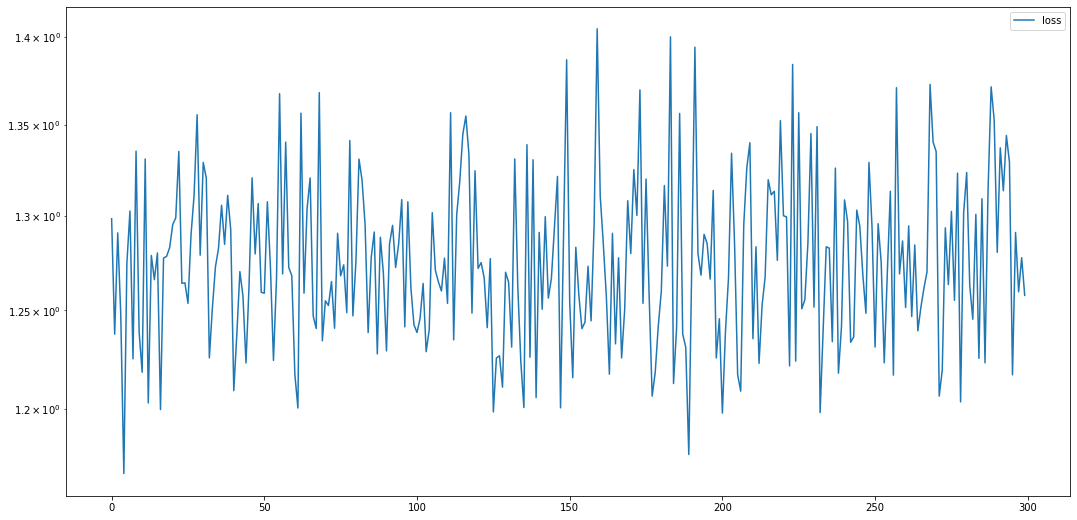

In [20]:
"""
hpd: ndarray
recopilamos los patrones de la señal aleatoria, y activamos el modelo de entrenamiento que pueda predecir la señal que deseamos.
graficamos la curva de aprendizaje.
"""

# fit model
X_in, y = split_sequence(X_train, n_steps)
history = model.fit(X_train, Y_train, epochs=300, batch_size=2,verbose= 0)

# learning curve
hpd = pd.DataFrame(history.history)
hpd[['loss']].plot(figsize=(18, 9))
plt.semilogy()
plt.show()

In [10]:
trainScore = model.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))


Train Score: 1.08 MSE (1.04 RMSE)


In [11]:
testScore = model.evaluate(X_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Test Score: 1.17 MSE (1.08 RMSE)


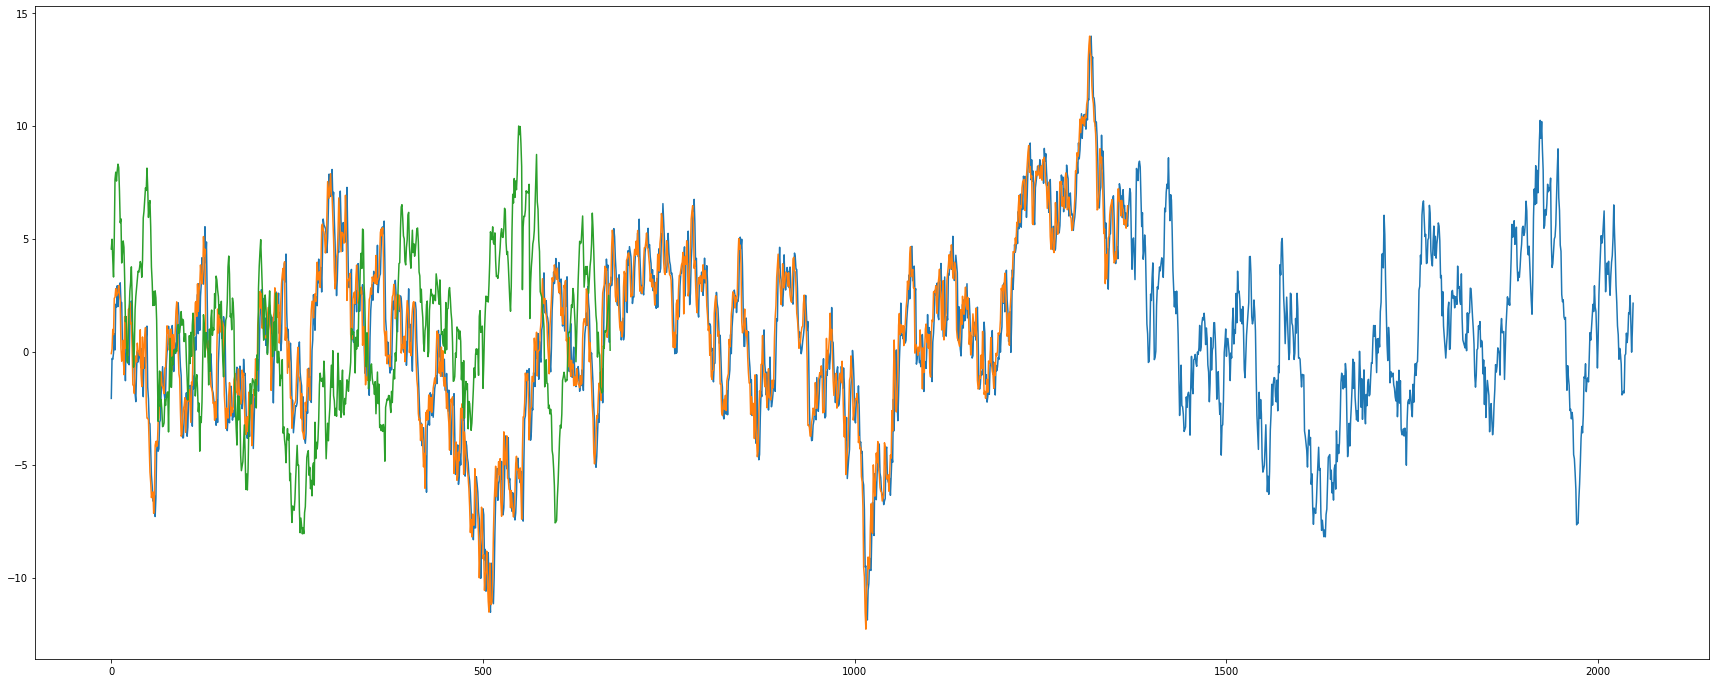

In [25]:
"""
trainpredict: ndarray

comparamos las señales que tomamos para predecir,  con la señal de ruido original. 
"""

# Evaluate the skill of the Trained model
trainPredict = np.array(model.predict(X_train))
trainPredict = np.reshape(trainPredict, (len(trainPredict), 1))
testPredict = np.array(model.predict(X_test))
testPredict = np.reshape(testPredict, (len(testPredict), 1))    

# plot baseline and predictions
plt.figure(figsize=(30,12))
plt.plot(dataset)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()

In [13]:
"""
X_predict: ndarray

le añadimos a la señal aleatoria una señal normal. la agrupamos en arreglos, y aplicamos la prediccion.
"""
# Estimate model performance
noise = np.random.normal(0, 0.1, size=n_samples)
X_predict = dataset + noise
X_predict, y_true = split_sequence(X_predict, n_steps)
y_hat = model.predict(X_predict)

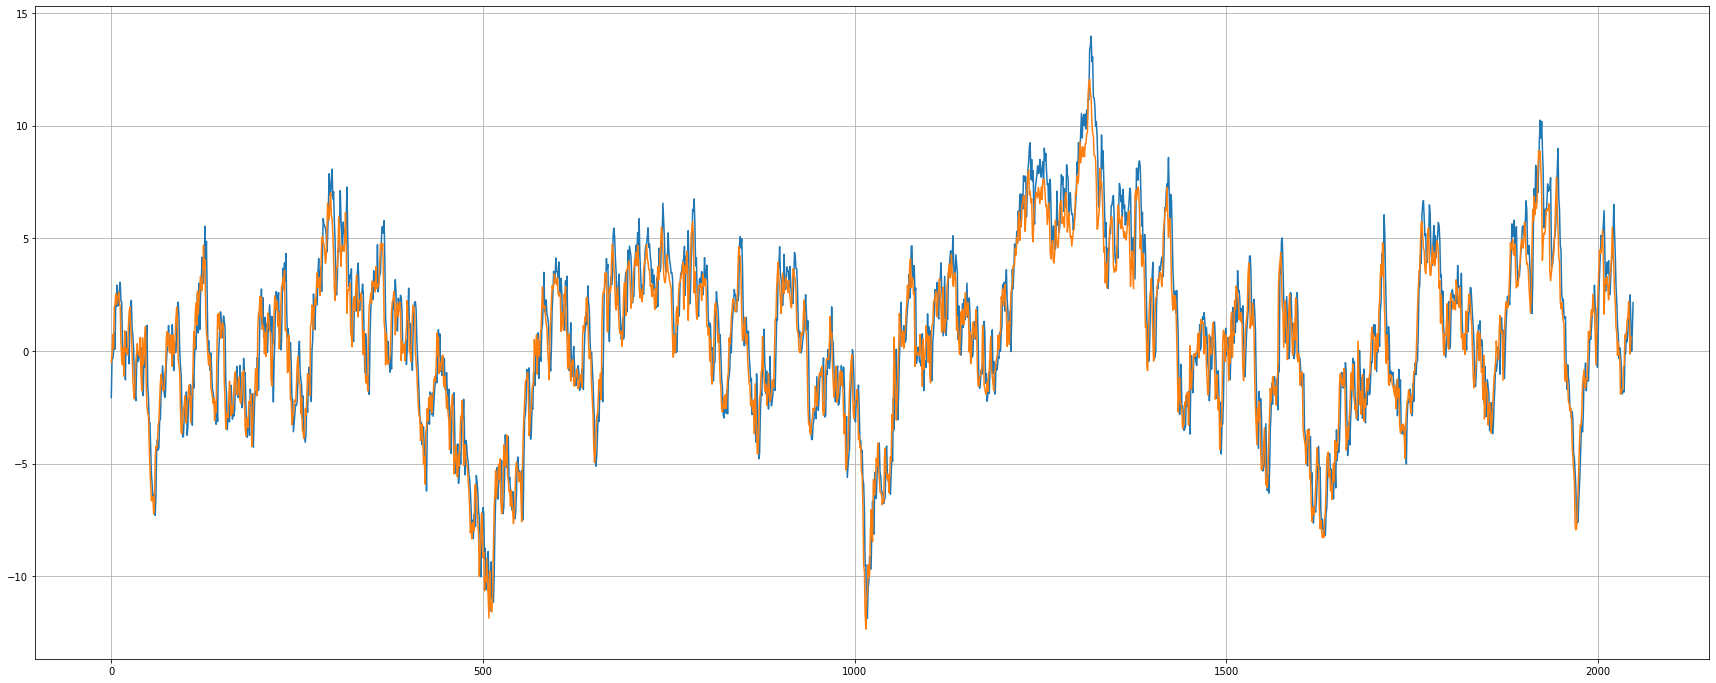

In [14]:
plt.figure(figsize=(30,12))
plt.plot(dataset)
plt.plot(y_hat)
plt.grid()

(array([  2.,   4.,   4.,   4.,   7.,   4.,   6.,  12.,  17.,  20.,  24.,
         32.,  38.,  36.,  39.,  59.,  78., 118., 123., 129., 110.,  99.,
        173., 105., 133., 132., 123.,  96.,  67.,  61.,  49.,  41.,  32.,
         28.,  11.,   7.,   9.,   7.,   1.,   0.,   3.,   2.]),
 array([-12.352084  , -11.771042  , -11.190001  , -10.608958  ,
        -10.027916  ,  -9.446875  ,  -8.865832  ,  -8.28479   ,
         -7.703748  ,  -7.1227064 ,  -6.5416646 ,  -5.9606223 ,
         -5.3795805 ,  -4.7985387 ,  -4.2174964 ,  -3.6364546 ,
         -3.0554125 ,  -2.4743707 ,  -1.8933287 ,  -1.3122867 ,
         -0.73124474,  -0.15020275,   0.4308392 ,   1.0118812 ,
          1.5929232 ,   2.1739652 ,   2.755007  ,   3.336049  ,
          3.9170911 ,   4.498133  ,   5.079175  ,   5.660217  ,
          6.241259  ,   6.822301  ,   7.4033427 ,   7.984385  ,
          8.565427  ,   9.146469  ,   9.72751   ,  10.308553  ,
         10.889595  ,  11.470636  ,  12.051679  ], dtype=float32),
 <a lis

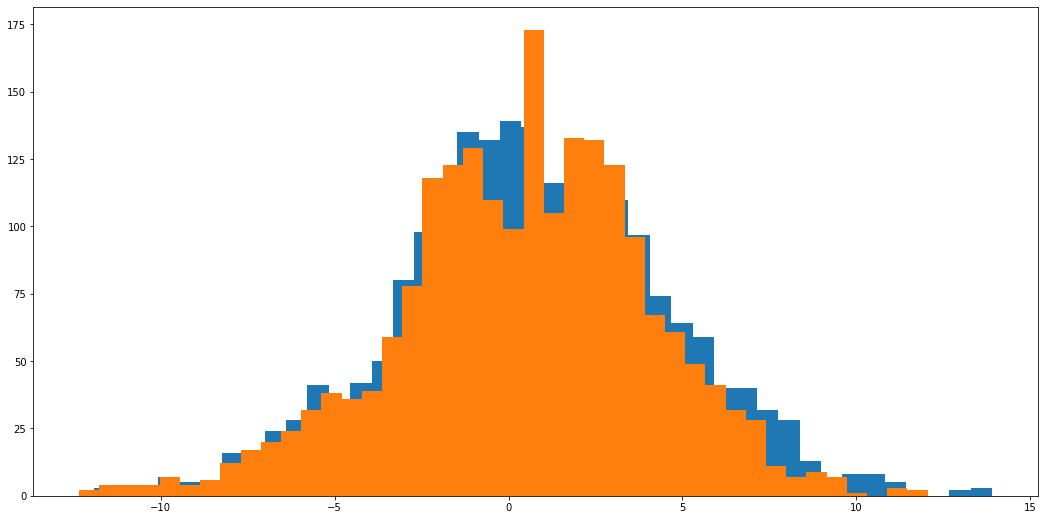

In [15]:
plt.figure(figsize=(18,9))
plt.hist(y_true,bins=42)
plt.hist(y_hat,bins=42)

NameError: ignored